In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np

In [2]:
%%time

df = pd.read_csv('data/examples.csv')
df.shape

CPU times: user 26 s, sys: 2.72 s, total: 28.8 s
Wall time: 30.3 s


(17937758, 9)

While attempting to train the model, it turned out that the reading and unpickling operation done at this scale, with so many files, is very computationally expensive.

But the examples in the mfcc represenatations are very small. Let's read them all into the memory before training.

In [3]:
uniq_fns = np.unique(df.target_fn.values)

In [4]:
uniq_fns[:5]

array(['000003ccee914766a64101e306727a7d',
       '0000043abbe34d9eb4444e71f42d98ec',
       '00000670bdea4bd19dae463ef7588299',
       '000008ccba824ba0a23db3ced81ed136',
       '000009eefcd0426393fae6d776a3743d'], dtype=object)

In [5]:
# %%time

# fn2feature = {}
# for fn in uniq_fns:
#     ary = pd.read_pickle(f'data/examples/{fn}.pkl')
#     fn2feature[fn] = ary

CPU times: user 22min 9s, sys: 5min 5s, total: 27min 14s
Wall time: 1h 10min 23s


In [6]:
# pd.to_pickle(fn2feature, 'data/fn2feature.pkl')

In [3]:
%%time
fn2features = pd.read_pickle('data/fn2feature.pkl')

CPU times: user 16.2 s, sys: 10.9 s, total: 27 s
Wall time: 27 s


I suspect that reading the data from a file saved within numpy (`numpy.save`) is much less computationally expensive than unpickling it, but I might be wrong. Either way, at ~4 million of unique utterances, the dataset is small enough to comfortably fit within memory of a GCP instance (at ~53GBs used RAM during training).

This might not be ideal for experimentation on home rigs. Saving the data using `numpy.save` and evaluating performance would definitely be a very interesting and useful exercise.

In [7]:
df.head()

,source_word,target_word,source_fn,target_fn,set_name,speaker_id,book_id,distance_from_target,audio_fpath
0,I,FELT,43a14fe66b6348718f089ec553bf57b1,b6c1288c07504236a2b054c972a6e92f,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
1,I,THAT,43a14fe66b6348718f089ec553bf57b1,ed9ceac76f7e49e7809ec56db40d37a2,train-clean-360,7000,83696,2,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
2,FELT,I,b6c1288c07504236a2b054c972a6e92f,43a14fe66b6348718f089ec553bf57b1,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
3,FELT,THAT,b6c1288c07504236a2b054c972a6e92f,ed9ceac76f7e49e7809ec56db40d37a2,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
4,FELT,IT,b6c1288c07504236a2b054c972a6e92f,235da027aeac418da43430e1f3470da4,train-clean-360,7000,83696,2,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac


In [4]:
train_examples = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])]
valid_examples = df[df.set_name == 'test-clean']

In [5]:
train_examples.size, valid_examples.size

(159688530, 1751292)

In [6]:
%%time

unique_fns = df.source_fn.unique()
np.random.shuffle(unique_fns)
lengths = []
for i, features in enumerate(fn2features.values()):
    lengths.append(features.shape[0])

CPU times: user 5.02 s, sys: 204 ms, total: 5.22 s
Wall time: 5.22 s


In [7]:
max(lengths)

291

In [8]:
features.shape

(18, 13)

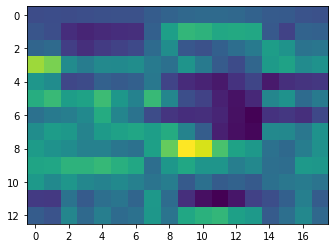

In [9]:
plt.imshow(features.T)

In [10]:
def prepare_features(fn, pad_to=max(lengths)):
    ary = fn2features[fn]
    example = np.zeros((pad_to, 13))
    example[:ary.shape[0], :] = ary
    return example.astype(np.float32)

In [14]:
dss = Datasets(
    df,
    [lambda row: prepare_features(row.source_fn),
     lambda row: prepare_features(row.target_fn),
     lambda row: prepare_features(row.target_fn)],
    n_inp=2,
    splits = [train_examples.index, valid_examples.index]
)

In [ ]:
dss[0]

In [15]:
BS = 2048
LR = 1e-3
NUM_WORKERS = 8

train_dl = DataLoader(dss.train, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(dss.valid, BS, NUM_WORKERS)

In [16]:
dls = DataLoaders(train_dl, valid_dl)

In [19]:
for batch in train_dl: break

In [66]:
class Model(Module):
    def __init__(self, hidden_size=50):
        self.encoder= nn.LSTM(
            input_size=13,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=False
        )
        self.decoder = nn.LSTM(
            input_size=13,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=True
        )
        self.lin = nn.Linear(2*hidden_size, 13)
            
    def forward(self, source_features, target_features):
        _, (embeddings, _) = self.encoder(source_features)
        embeddings_bi = torch.cat((embeddings, torch.flip(embeddings, (2,))))
        x, _ = self.decoder(target_features, (embeddings_bi, torch.zeros_like(embeddings_bi)))
        x = self.lin(x)
        return x

In [67]:
from torch.nn import MSELoss

learn = Learner(dls.cuda(), Model().cuda(), loss_func=MSELoss(), lr=1e-3)

In [68]:
learn.fit(4)

epoch,train_loss,valid_loss,time
0,0.011743,0.011293,45:50
1,0.008753,0.008639,46:23
2,0.007835,0.007880,45:44
3,0.007409,0.008419,45:28


In [69]:
# learn.save('basic_model_4epochs_1e-3')

Path('models/basic_model_4epochs_1e-3.pth')

In [48]:
learn.load('basic_model_4epochs_1e-3')

In [70]:
all_dl = DataLoader(dss, BS, NUM_WORKERS)

In [71]:
with torch.no_grad():
    learn.model.train = False
    for batch in all_dl:
        _, (embeddings, _) = learn.model.encoder(batch[0].cuda())
        break

In [73]:
embeddings

tensor([[[ 0.9804,  0.5087, -0.9841,  ..., -0.9235,  0.9040, -0.0262],
         [ 0.9804,  0.5087, -0.9841,  ..., -0.9235,  0.9040, -0.0262],
         [ 0.9804,  0.5087, -0.9841,  ..., -0.9235,  0.9040, -0.0262],
         ...,
         [ 0.9804,  0.5087, -0.9841,  ..., -0.9235,  0.9040, -0.0262],
         [ 0.9804,  0.5087, -0.9841,  ..., -0.9235,  0.9040, -0.0262],
         [ 0.9804,  0.5087, -0.9841,  ..., -0.9235,  0.9040, -0.0262]]],
       device='cuda:0')

As it turns out, this model isn't learning anything useful. For any of the inputs,the decoder will output the same embeddings.

There might be other issues causing this, but my guess is that this is related to teacher forcing all the way throughout the training.

The next steps will certainly consist of replacing the cudnn optimized prediction loop for the decoder and replacing it with something of our own creation.